# EMG Hand Gesture Classification

This project utilizes data sourced from UCI's Machine Learning Repository (linked below). The data was collected across 36 participants, each performing 2 sets of 8 gestures, with each gesture being performed for a duration of 3 seconds. The objective of this project is to evaluate the difference in performance between windowing and non-windowing data processing techniques for gesture classification using modern EMG equipment. The results of this study can help in the efficient processing of EMG signals with hardware acceleration.

Data Source:
https://archive.ics.uci.edu/dataset/481/emg+data+for+gestures


## Data Processing

With the help of the `glob` package, we can join all of the data together into a master dataset. For the simpler models, we will not be incorporating any temporal features, which makes the makes the analysis much simpler--each channel is treated as a dimension, and some transformation of each of these features will yield a class result.

In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = []  # list to store each data file

# Iterating over every .txt file in the EMG_data folder
for file in glob.glob('EMG_data/**/*.txt'):
    data.append(pd.read_table(file, delimiter='\t'))

data = pd.concat(data, axis=0)  # concatenating list of dfs together
data.fillna(0, inplace=True)  # filling na values (only 1)
data['class'] = data['class'].astype(int)  # converting class to int

# Making sure data is loaded in correctly
print(f'Shape of data: {data.shape}')
display(data.head())

Shape of data: (4237908, 10)


,time,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8,class
0,1,-0.00004,-0.00002,-0.00001,-0.00002,-0.00001,-0.00001,0.00002,-0.00001,0
1,4,-0.00004,-0.00002,-0.00001,-0.00002,-0.00001,-0.00001,0.00002,-0.00001,0
2,5,-0.00004,-0.00002,-0.00001,-0.00002,-0.00001,-0.00001,0.00002,-0.00001,0
3,6,-0.00004,-0.00002,-0.00001,-0.00002,-0.00001,-0.00001,0.00002,-0.00001,0
4,7,-0.00002,-0.00001,0.00000,0.00001,0.00000,-0.00001,-0.00002,0.00001,0


To understand the proportion of each class label, we can visualize proportions for each class label. This will aid in choosing an appropriate modelling technique for the dataset.

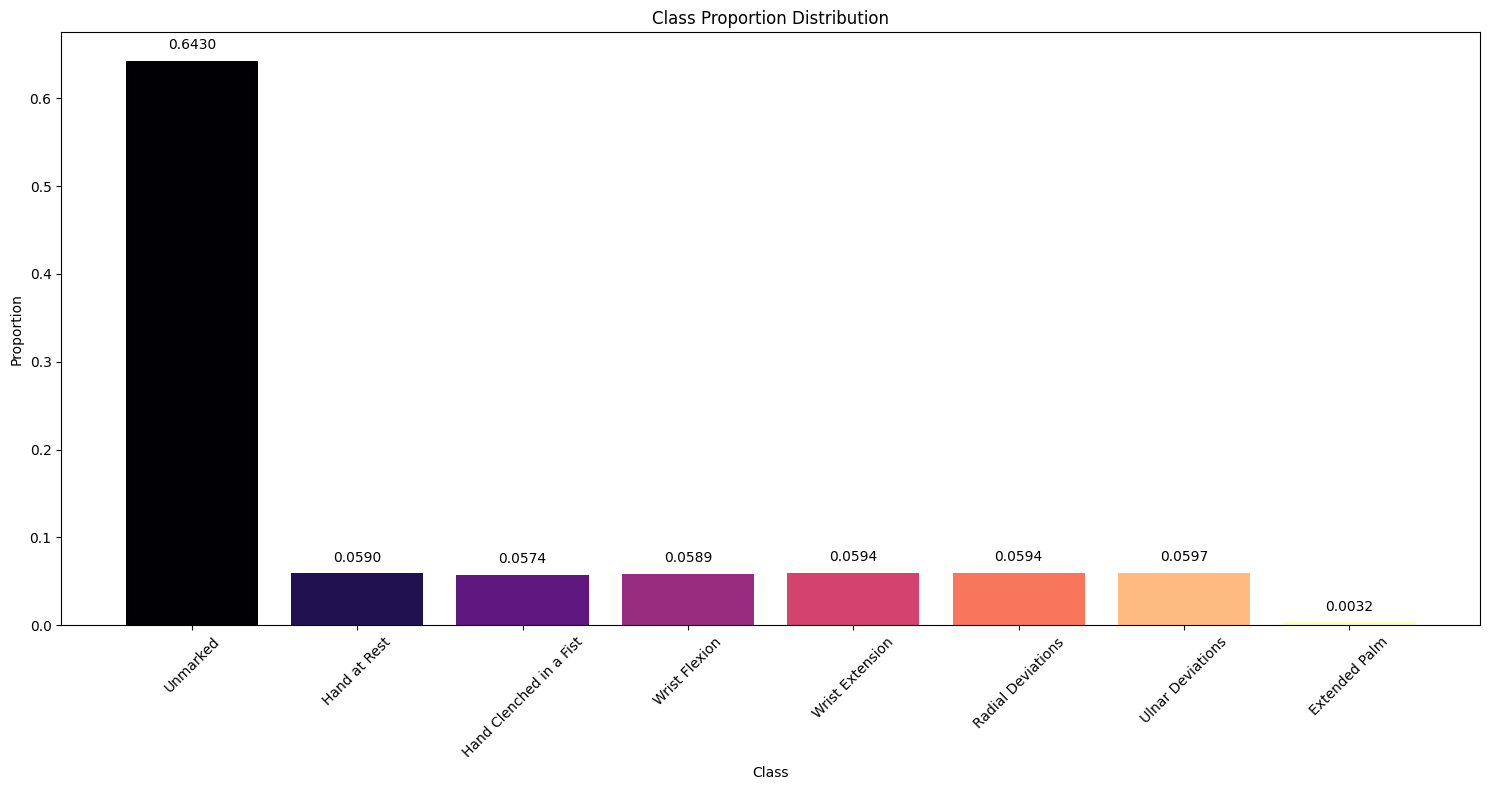

In [3]:
label_map = {
    0: 'Unmarked',
    1: 'Hand at Rest',
    2: 'Hand Clenched in a Fist',
    3: 'Wrist Flexion',
    4: 'Wrist Extension',
    5: 'Radial Deviations',
    6: 'Ulnar Deviations',
    7: 'Extended Palm'
}

# Constructing proportions dataframe
proportions = (pd.DataFrame(
        data.groupby(by='class').count().mean(axis=1),
        columns=['proportion']) / data.shape[0]).reset_index()

# Mapping classes labels for visualization
proportions.replace({'class': label_map}, inplace=True)
num_classes = proportions['class'].nunique()
colors = plt.cm.magma(np.linspace(0, 1, num_classes))

# Visualizing data
fig, ax = plt.subplots(figsize=(15, 8))
bars = ax.bar(proportions['class'], proportions['proportion'], color=colors)
ax.set_xticks(range(len(proportions['class'])))
ax.set_xticklabels(proportions['class'], rotation=45)
for bar, proportion in zip(bars, proportions['proportion']):  # adding proportions to viz
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.01,
        f'{proportion:.4f}',
        ha='center', va='bottom'
    )

ax.set_xlabel('Class')
ax.set_ylabel('Proportion')
ax.set_title('Class Proportion Distribution')
plt.tight_layout()
plt.show()

The dataset seems to be very imbalanced, with most of the data points being 'Unmarked'. For tabular datasets with minimal noise, we can apply data imputation techniques like SMOTE to add synthetic data. However, EMG signals are extremely noisy, so synthetic data generation would require very complex models.

## Windowing (Industry Standard)

As a baseline measure of performance, we will be windowing the data across time. The main idea is that the current time step of the signal may not hold all the relevant information required and that prior data points have an influence on the current gesture. To process this data, I've developed a custom framework that utilizes a convolutional neural network (CNN) for feature extraction, deep-cross network (DCN) for efficient feature crossing, and multilayer perceptron (MLP) for classification.

This pipeline effectively utilizes GPU for faster computation. I will be using Apple's Metallic Performance Shaders (MPS) device that is built into my MacBook to simulate a reasonable hardware accelerator that could be localized on a prosthetic.

In [21]:
from windowing.data_processing import split_sequences
from windowing.model import EMGDataModule, BaselineEMGModel
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
import pytorch_lightning as pl
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [5]:
sequence_length = 16
X, y = split_sequences(data, sequence_length, fft=True)
print(X.shape, y.shape)

  0%|          | 0/4237907 [00:00<?, ?it/s]

torch.Size([4236828, 10, 16]) torch.Size([4236828])


We are processing the data much faster than the sampling rate, which is great for realtime applications.

In [6]:
# Initialize the DataModule with test data
data_module = EMGDataModule(
    X=X,
    y=y,
    batch_size=2048,
    val_split=0.2,
    test_split=0.3,
    scale_data=True
)

# Initialize the model
num_features = 16  # channels
embed_dim = 256  # embedding dimensions
num_classes = int(y.max().item()) + 1  # number of classes based on labels
lr = 0.001
dropout = 0.1
l1_reg = 0  # made results terrible

model = BaselineEMGModel(
    num_features=num_features,
    embed_dim=embed_dim,
    num_classes=num_classes,
    lr=lr,
    dropout=dropout,
    l1_reg=l1_reg
)

# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # metric
    patience=20,
    mode='min'
)

# Saving best model
checkpoint = ModelCheckpoint(
    monitor='val_loss',
    mode='min',
    save_top_k=3,
    filename='model-{epoch:02d}-{val_loss:.2f}',  # filename
    save_last=False
)

In [7]:
# Initialize the Trainer (change device here if needed)
trainer = pl.Trainer(
    max_epochs=500,
    # gpus=1 if torch.cuda.is_available() else 0,
    callbacks=[early_stopping, checkpoint],
    accelerator='mps' if torch.backends.mps.is_available() else 'cpu'
)

# Train the model
trainer.fit(model, datamodule=data_module)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | loss_fn | CrossEntropyLoss | 0      | train
1 | conv1   | Sequential       | 10.6 K | train
2 | conv2   | Sequential       | 131 K  | train
3 | fm1     | Linear           | 65.8 K | train
4 | fm2     | Linear           | 65.8 K | train
5 | fm3     | Linear           | 65.8 K | train
6 | fc      | Sequential       | 46.5 M | train
-----------------------------------------------------
46.8 M    Trainable params
0         Non-trainable params
46.8 M    Total params
187.215   Total estimated model params size (MB)
41        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [8]:
#%tensorboard --logdir lightning_logs/
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

#### Test the model

In the below code block, enter the filepath to the checkpoint.

In [9]:
CHECKPOINT = 'lightning_logs/version_44/checkpoints/model-epoch=226-val_loss=0.15.ckpt'

In [10]:
data_module = EMGDataModule(
    X=X,
    y=y,
    batch_size=2048,
    val_split=0.2,
    test_split=0.3,
    scale_data=True
)

model = BaselineEMGModel.load_from_checkpoint(CHECKPOINT)

# Change device here if needed
trainer = pl.Trainer(callbacks=[checkpoint], accelerator='mps' if torch.backends.mps.is_available() else 'cpu')

trainer.test(model=model, datamodule=data_module)
results = model.test_results

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Testing: |                                                | 0/? [00:00<?, ?it/s]

In [12]:
y_pred = torch.argmax(results['y_pred'], -1).reshape(-1)
y_true = results['y_true'].reshape(-1)
print(y_pred.shape, y_true.shape)

torch.Size([1271048]) torch.Size([1271048])


In [19]:
print('Accuracy of Model:')
print((torch.sum(y_pred==y_true) / y_pred.shape[0]).item())

Accuracy of Model:
0.9795278906822205


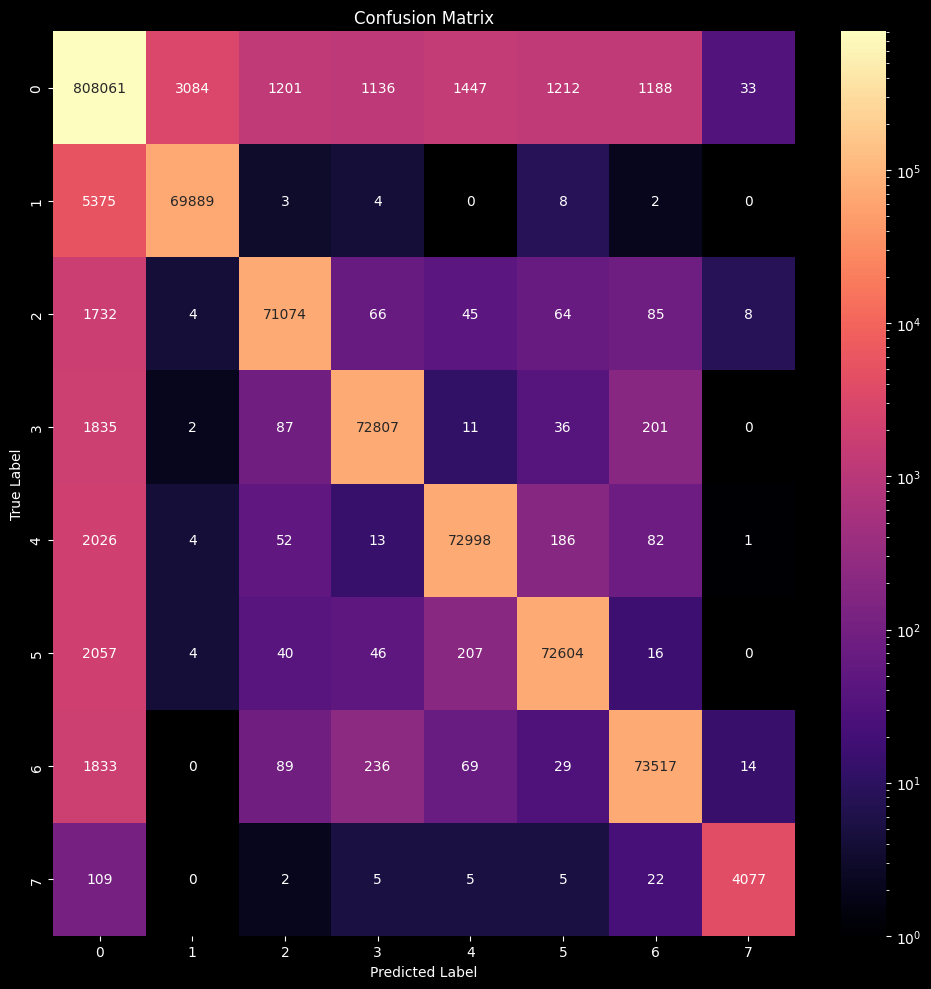

In [22]:
plt.style.use("dark_background")
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='magma', norm=LogNorm())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

## Non-Windowing

To compare the efficacy of windowing, let's compare baseline machine learning models and a deep learning model that do not window the data, and instead use each time step as a single sample.

### Baseline Machine Learning

To deal with class imbalance, the `LogisticRegression`, `LinearSVC`, and `RandomForestClassifier` classes by `sklearn` provide a `class_weight` hyperparameter. We will compare the efficacy of these models with and without this hyperparameter, and evaluate the performance as a baseline for the non-windowing model.

To do this, let's make sure that our training and testing data is setup up correctly and standardized with mean of $0$ and variance of $1$.

In [3]:
from non_windowing.visualization import visualize_results
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
import time

In [4]:
X, y = data.iloc[:, 1:-1].values, data.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=101, test_size=0.4, shuffle=True)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('\nX_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (2542744, 8)
y_train shape: (2542744,)

X_test shape: (1695164, 8)
y_test shape: (1695164,)


To make sure that the model is not influenced by unseen data, let's reconstruct the proportions to assign class weights for the models.

In [5]:
# Calculate proportions based on training data only
class_counts = Counter(y_train)
total_samples = len(y_train)
class_weights = {cls: total_samples / count for cls, count in class_counts.items()}

# Normalize the weights
total_weight = sum(class_weights.values())
class_weights = {cls: weight / total_weight for cls, weight in class_weights.items()}

Logistic Regression (Unbalanced) Results:
Training Time: 19.480 seconds
Testing Time: 0.048 seconds
Model accuracy: 0.6426074409319689


/Users/chai/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chai/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chai/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


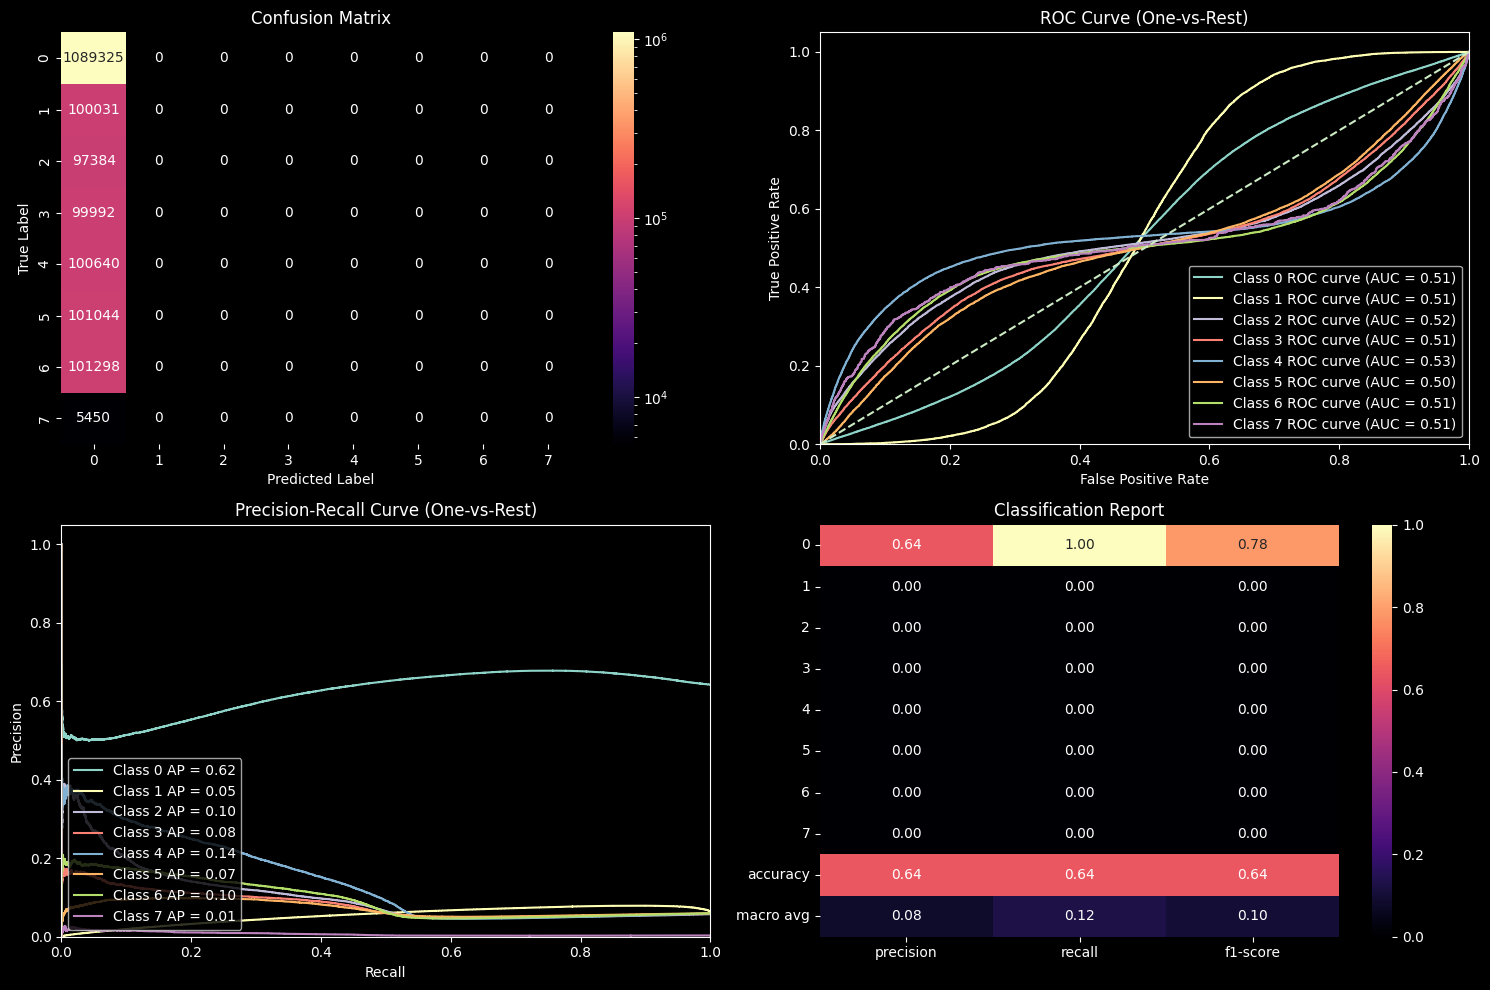

Logistic Regression (Balanced) Results:
Training Time: 17.311 seconds
Testing Time: 0.067 seconds
Model accuracy: 0.06311188769936124


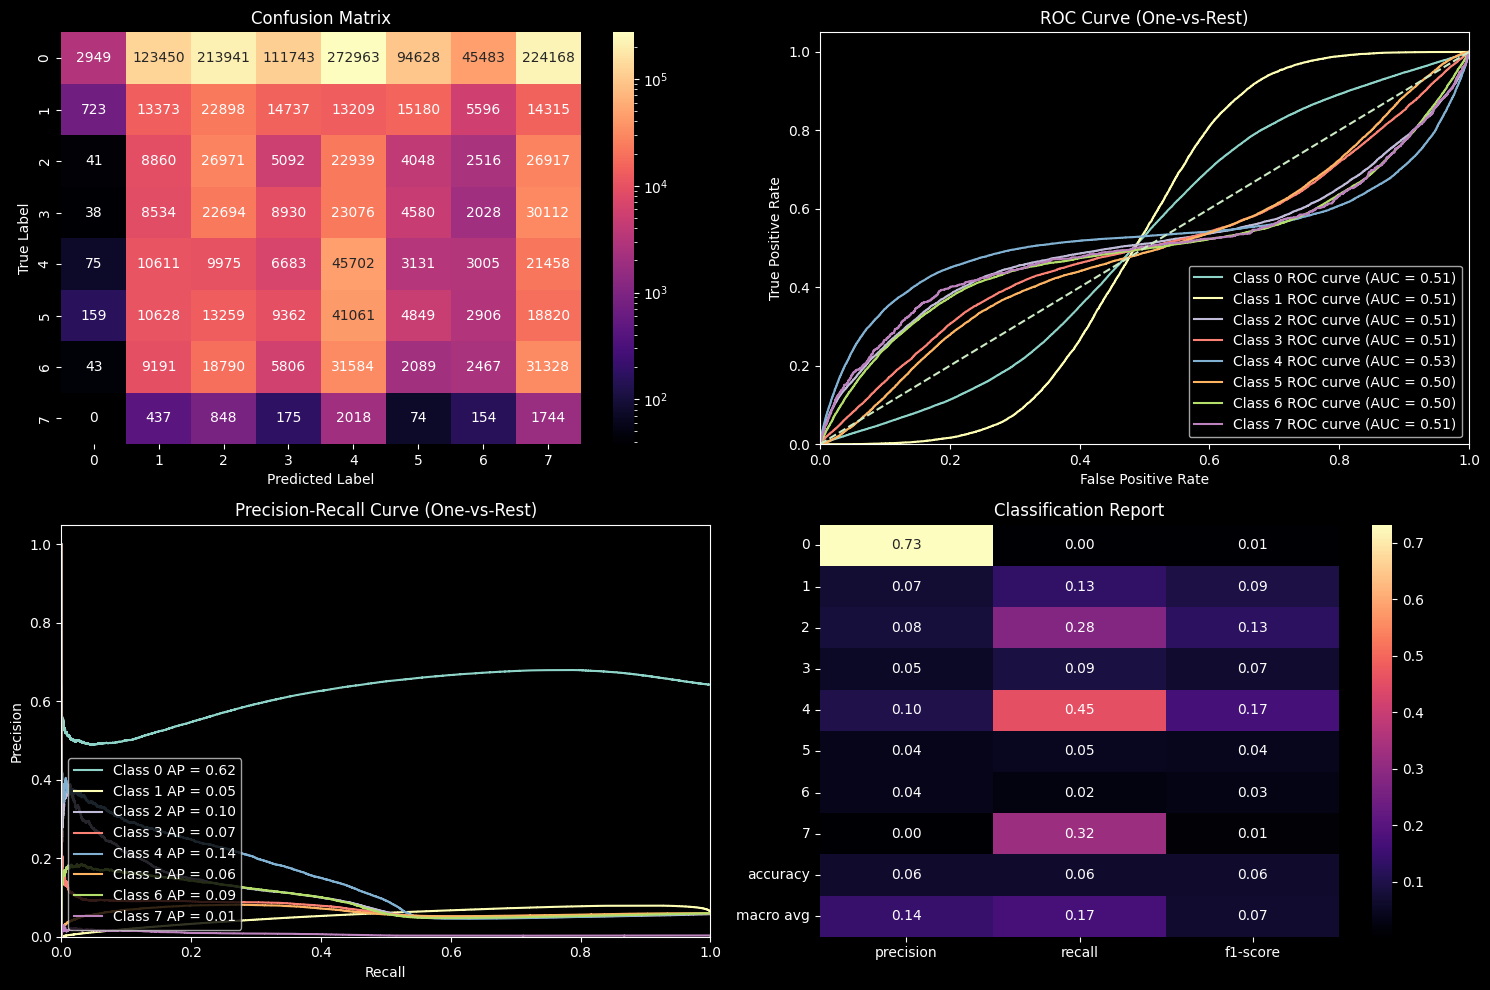

Linear SVM  (Unbalanced) Results:
Training Time: 52.455 seconds
Testing Time: 1.125 seconds
Model accuracy: 0.6426074409319689


/Users/chai/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chai/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chai/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


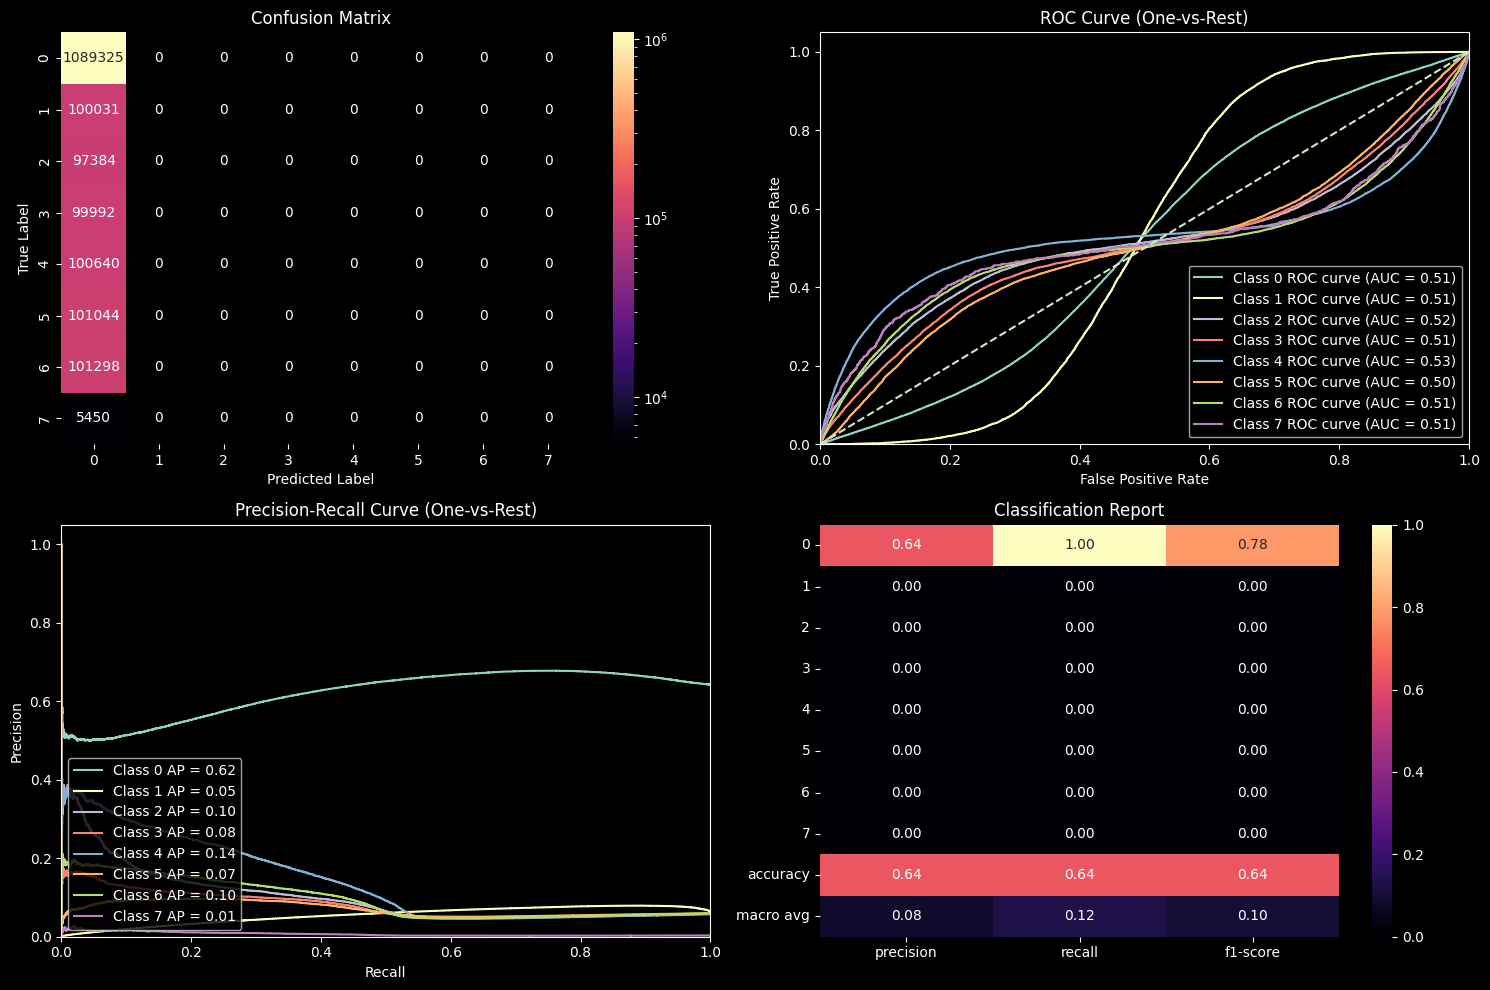

Linear SVM (Balanced) Results:
Training Time: 60.033 seconds
Testing Time: 1.128 seconds
Model accuracy: 0.6426074409319689


/Users/chai/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chai/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chai/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


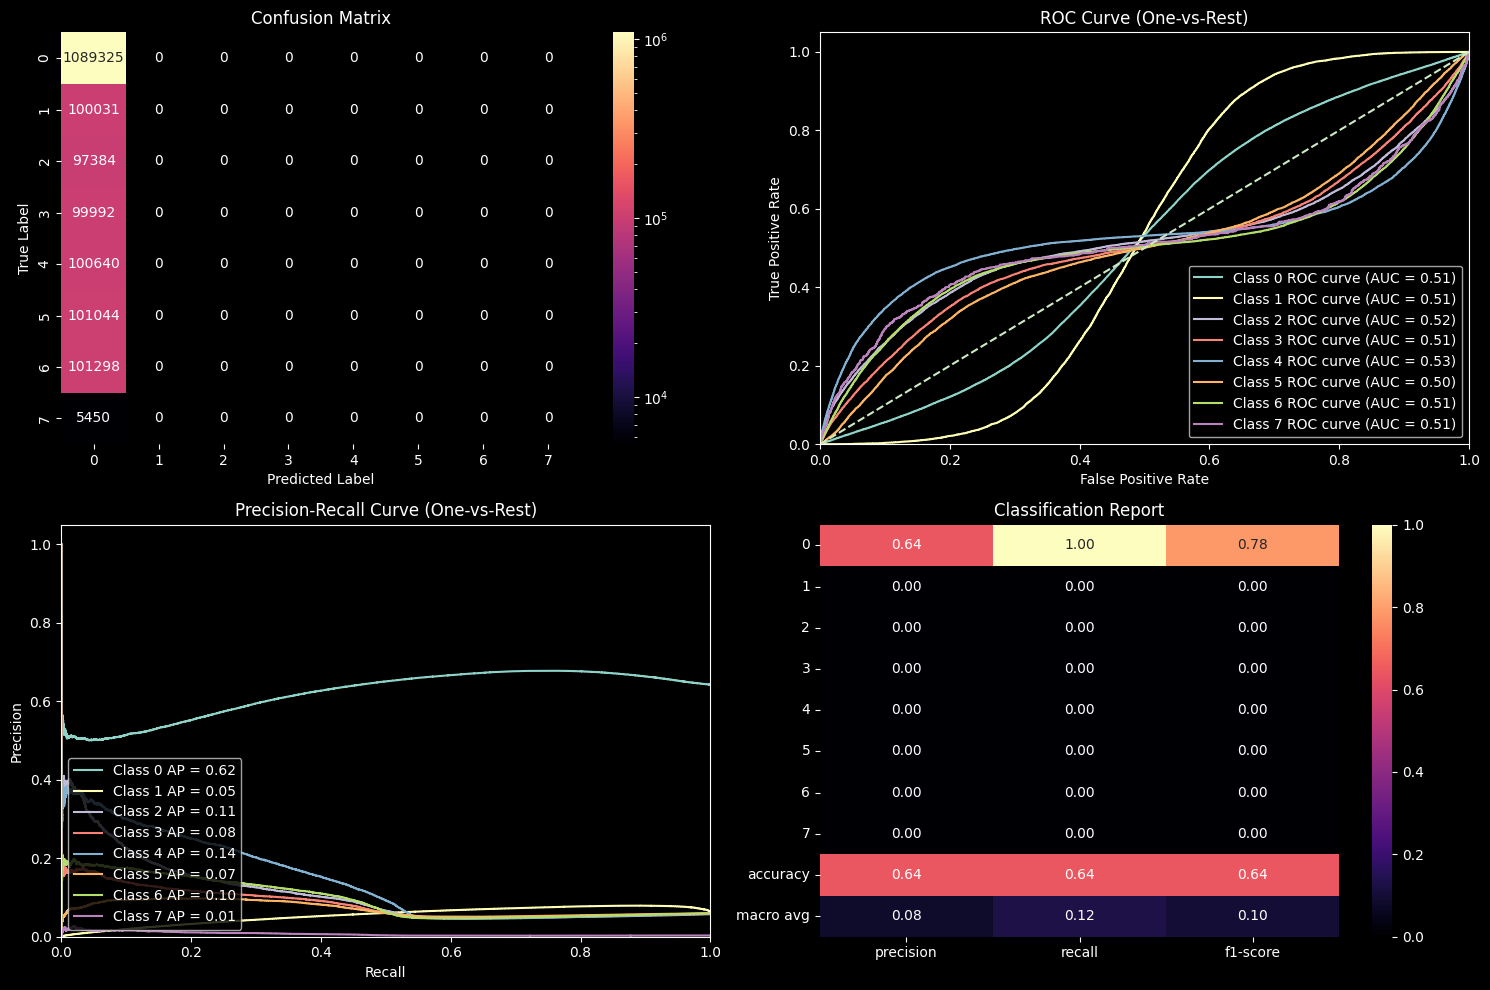

Random Forest (Balanced) Results:
Training Time: 12.982 seconds
Testing Time: 3.168 seconds
Model accuracy: 0.9787247723524095


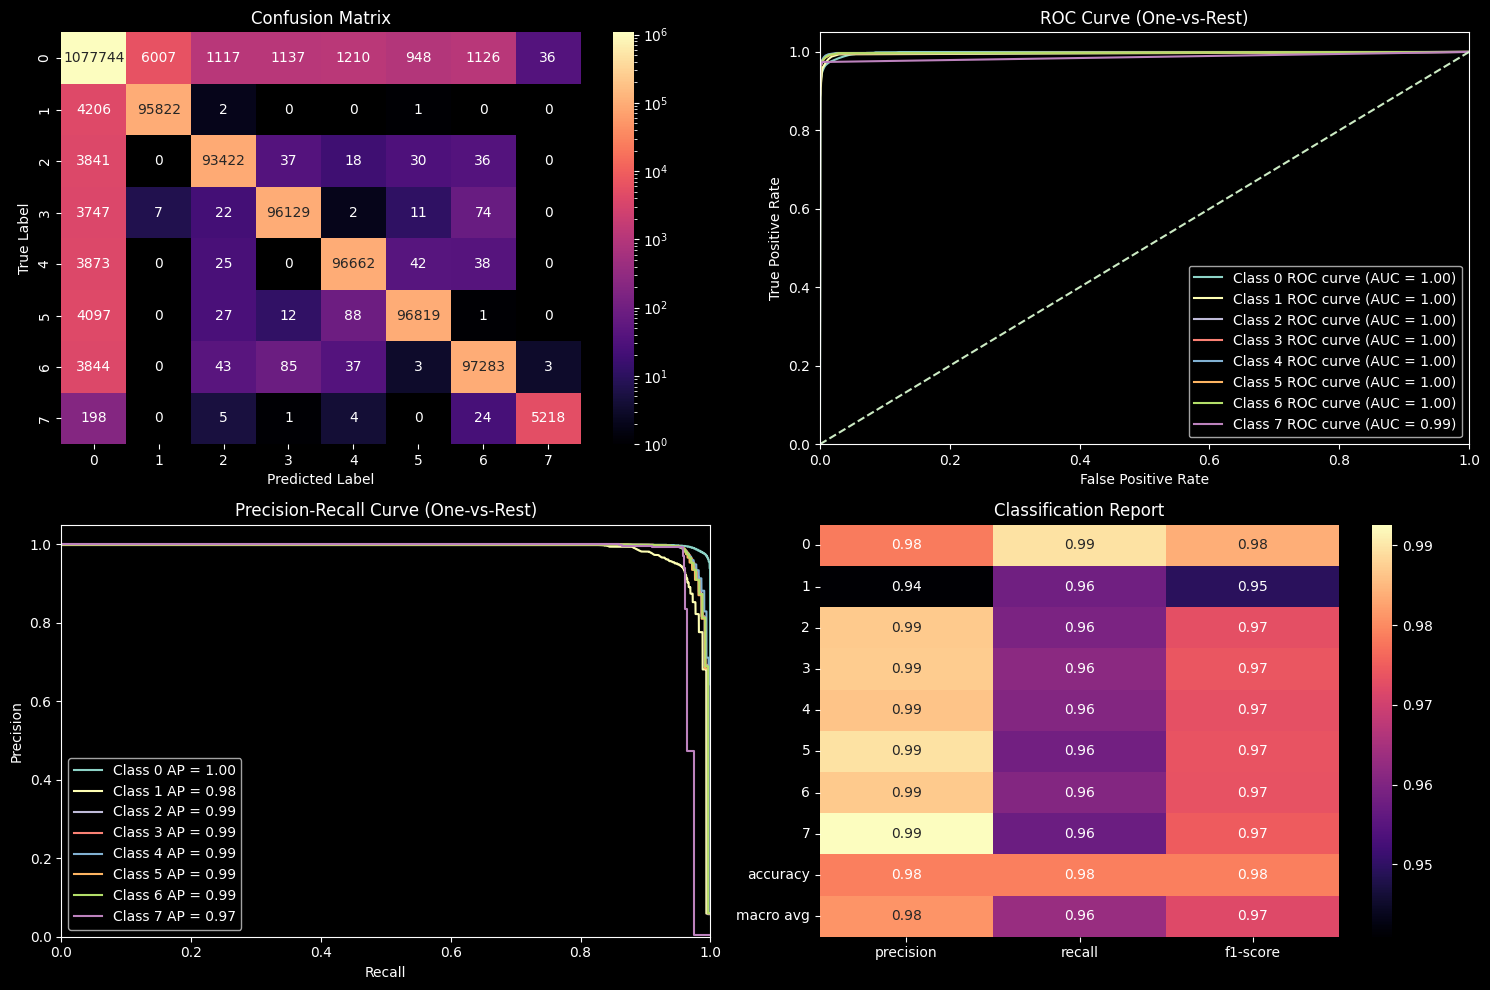

Random Forest (Unbalanced) Results:
Training Time: 12.743 seconds
Testing Time: 3.099 seconds
Model accuracy: 0.9801488233586839


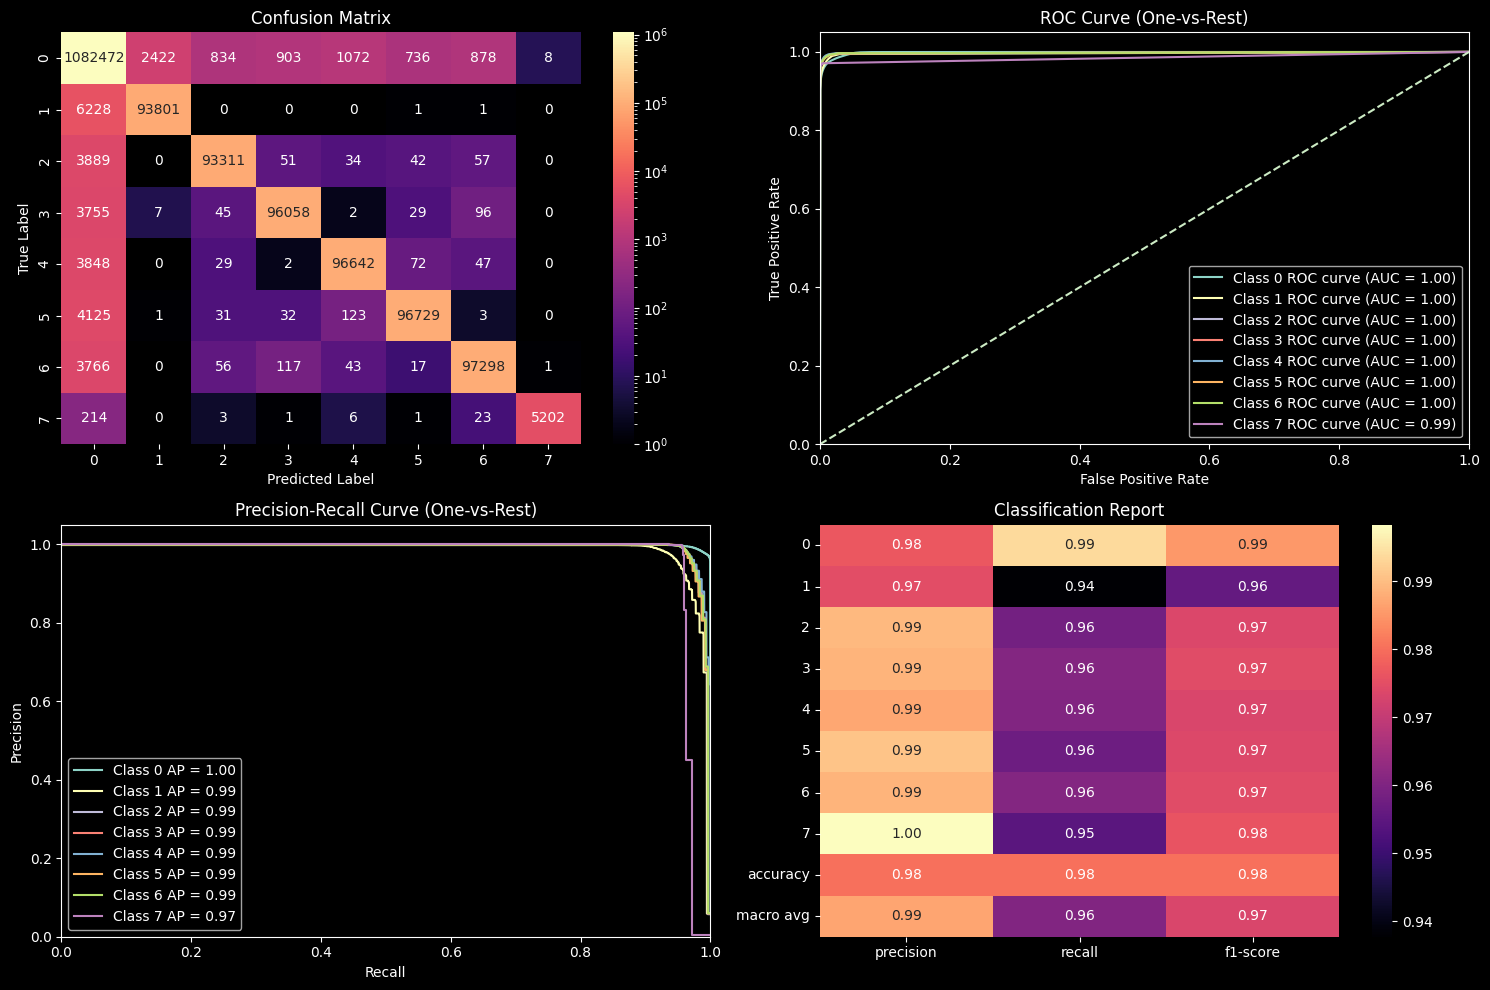

In [7]:
models = {
    'Logistic Regression (Unbalanced)': LogisticRegression(
    solver='sag',
    tol=1e-2,
    n_jobs=-1
    ),
    'Logistic Regression (Balanced)': LogisticRegression(
        solver='sag',
        tol=1e-2,
        class_weight=class_weights,
        n_jobs=-1
    ),
    'Linear SVM  (Unbalanced)': CalibratedClassifierCV(
        LinearSVC(
            dual='auto'
        )
    ),
    'Linear SVM (Balanced)': CalibratedClassifierCV(
        LinearSVC(
            dual='auto',
            class_weight=class_weights
        )
    ),
    'Random Forest (Balanced)': RandomForestClassifier(
        n_estimators=25,
        class_weight=class_weights,
        n_jobs=-1
    ),
    'Random Forest (Unbalanced)': RandomForestClassifier(
        n_estimators=25,
        n_jobs=-1
    )
}  # dictionary of models with some minimally tuned hyperparameters

# Training each model and visualizing results
for name, model in models.items():
    start = time.time()
    
    model.fit(X_train, y_train)
        
    print(f'\033[1m\033[4m{name} Results\033[0m:')
    end = time.time()
    training_time = end - start
    print(f'Training Time: {training_time:.3f} seconds')
    visualize_results(X_test, y_test, model)

It seems that adding the `class_weight` parameter might be making these models worse overall. The random forest classifier has performed extremely well, even outperforming some deep neural network architectures, but it is limited by the delay in testing time. For EMG signal classification in real world applications, testing speed is quintessential for immediate responses, especially when dealing with robotic proshetics and such.

### Deep Learning Approach (Proposition)

By utilizing a deep learning model with hardware acceleration, we can evaluate the necessity of windowing on the dataset, while boosting test time compared to the baseline ML approach.

In [9]:
from non_windowing.visualization import visualize_results
from non_windowing.model import OPNNDataModule, OPNN
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
import pytorch_lightning as pl
import torch
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm
import seaborn as sns
from sklearn.metrics import confusion_matrix

/Users/chai/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [10]:
X, y = torch.tensor(data.iloc[:, 1:-1].values), torch.tensor(data.iloc[:, -1].values)
print(X.shape, y.shape)

torch.Size([4237908, 8]) torch.Size([4237908])


In [11]:
# Initialize the DataModule with test data
data_module = OPNNDataModule(
    X=X,
    y=y,
    batch_size=2048,
    val_split=0.2,
    test_split=0.3,
    scale_data=True
)

# Initialize the model
num_features = 8  # channels
num_classes = int(y.max().item()) + 1  # number of classes based on labels
lr = 0.0001
dropout = 0.0
l1_reg = 0  # made results terrible

model = OPNN(
    num_features=num_features,
    num_classes=num_classes,
    lr=lr,
    dropout=dropout,
    l1_reg=l1_reg
)

# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # metric
    patience=20,
    mode='min'
)

# Saving best model
checkpoint = ModelCheckpoint(
    monitor='val_loss',
    mode='min',
    save_top_k=3,
    filename='opnn-fc-{epoch:02d}-{val_loss:.2f}',  # filename
    save_last=False
)

# Initialize the Trainer
trainer = pl.Trainer(
    max_epochs=500,
    # gpus=1 if torch.cuda.is_available() else 0,
    callbacks=[early_stopping, checkpoint],
    accelerator='mps' if torch.backends.mps.is_available() else 'cpu'
)

# Train the model
trainer.fit(model, datamodule=data_module)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | loss_fn | CrossEntropyLoss | 0      | train
1 | fc      | Sequential       | 11.0 M | train
-----------------------------------------------------
11.0 M    Trainable params
0         Non-trainable params
11.0 M    Total params
44.198    Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/chai/Library/Python/3.9/lib/python/site-packages/torch/__init__.py", line 2059, in <module>
    from torch import (
  File "/Users/chai/Library/Python/3.9/lib/python/site-packages/torch/hub.py", line 19, in <module>
    from urllib.request import Request, urlopen
  File "<frozen importlib._bootstrap>", line 1007, in _find_and_load
  File "<frozen importlib._bootstrap>", line 986, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>"

NameError: name 'exit' is not defined

In [12]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

#### Test the model

In the below code block, enter the filepath to the checkpoint.

In [13]:
CHECKPOINT = 'lightning_logs/version_49/checkpoints/opnn-fc-epoch=43-val_loss=0.19.ckpt'

In [14]:
data_module = OPNNDataModule(
    X=X,
    y=y,
    batch_size=2048,
    val_split=0.2,
    test_split=0.3,
    scale_data=True
)

model = OPNN.load_from_checkpoint(CHECKPOINT)

# Change device here if needed
trainer = pl.Trainer(callbacks=[checkpoint], accelerator='mps' if torch.backends.mps.is_available() else 'cpu')

trainer.test(model=model, datamodule=data_module)
results = model.test_results

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Testing: |                                                | 0/? [00:00<?, ?it/s]

In [15]:
y_pred = torch.argmax(results['y_pred'], -1).reshape(-1)
y_true = results['y_true'].reshape(-1)
print(y_pred.shape, y_true.shape)

torch.Size([1271372]) torch.Size([1271372])


In [16]:
print('Accuracy of Model:')
print((torch.sum(y_pred==y_true) / y_pred.shape[0]).item())

Accuracy of Model:
0.9843460321426392


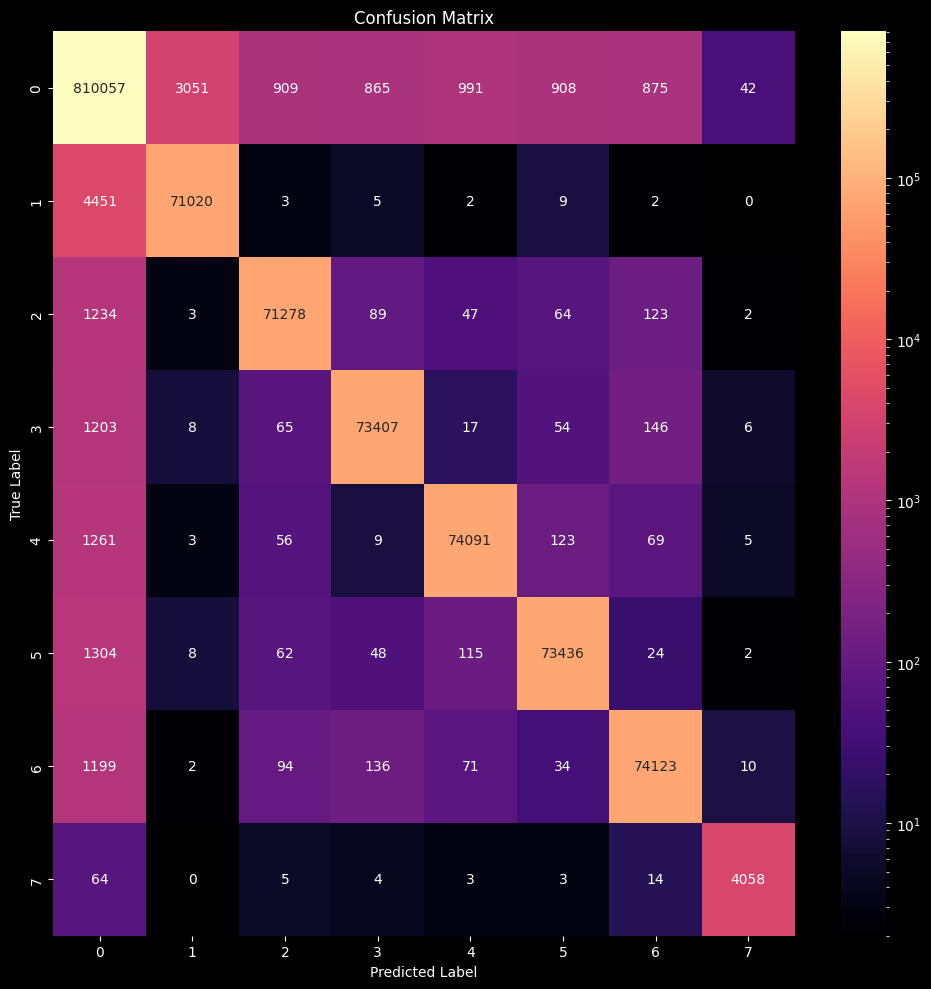

In [17]:
plt.style.use("dark_background")
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='magma', norm=LogNorm())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()